In [27]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import shap
from Modules import plots
from sklearn.metrics import accuracy_score, precision_score, recall_score
import wandb

import warnings
warnings.filterwarnings("ignore")


In [2]:
file_path = "dataframe/train_data_enriched.csv"  
df = pd.read_csv(file_path)

In [ ]:

df = df.dropna()


colonnes_utiles = [
    'shot_distance', 'shot_angle', 'is_goal', 
]
df1 = df[colonnes_utiles]


In [5]:

X = df1.drop('is_goal', axis=1)  
y = df1['is_goal']              

# Diviser les données
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Vérifiez les dimensions
print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}")


Train set: (351956, 2), Validation set: (87989, 2)


In [6]:
# Train an XGBoost model
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb.fit(X_train, y_train)



c:\Users\hicha\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [16:06:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [7]:

# Generate predictions
y_pred_proba = model_xgb.predict_proba(X_val)[:, 1]
roc_data_xgb = plots.generate_roc_auc_data(y_val, y_pred_proba)
goal_rate_x, goal_rate_y = plots.generate_goal_rate_data(y_val, y_pred_proba)
cumulative_x, cumulative_y = plots.generate_cumulative_goal_data(y_val, y_pred_proba)
calibration_prob_pred, calibration_prob_true = plots.generate_calibration_data(y_val, y_pred_proba)

In [8]:
# Generate predictions
y_pred_proba = model_xgb.predict_proba(X_val)[:, 1]  # Probabilities
y_pred = (y_pred_proba >= 0.5).astype(int)           

# Calculate ROC/AUC and other plots
roc_data_xgb = plots.generate_roc_auc_data(y_val, y_pred_proba)
goal_rate_x, goal_rate_y = plots.generate_goal_rate_data(y_val, y_pred_proba)
cumulative_x, cumulative_y = plots.generate_cumulative_goal_data(y_val, y_pred_proba)
calibration_prob_pred, calibration_prob_true = plots.generate_calibration_data(y_val, y_pred_proba)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)

In [9]:
# Plot ROC/AUC
plots.plot_roc_auc([roc_data_xgb], ['XGBoost'],"roc_5_1.png")

# Plot Goal Rate vs Percentile
plots.plot_goal_rate([(goal_rate_x, goal_rate_y)], ['XGBoost'],"goal_rate_5_1.png")

# Plot Cumulative Goals vs Percentile
plots.plot_cumulative_goals([(cumulative_x, cumulative_y)], ['XGBoost'],"cumulative_goals_5_1.png")

# Plot Calibration Curve
plots.plot_calibration([y_val], [y_pred_proba], ['XGBoost'],"calibration_5_1.png")


<Figure size 1200x800 with 0 Axes>

In [12]:
wandb.init(
    project="IFT6758.2024-A",
    name="Baseline_XGBoost_Q5_1",
    notes="Classificateur XGBoost en utilisant les caractéristiques de distance et d' angle"
)
wandb.log({
    "accuracy": accuracy,  
    "roc_auc": roc_data_xgb['roc_auc'],
})
# Log the image to W&B
wandb.log({"roc_curve_5_1": wandb.Image("roc_5_1.png", caption="ROC Curve for  5.1")})
wandb.log({"goal_rate_5_1": wandb.Image("goal_rate_5_1.png", caption="Goal Rate Curve for  5.1")})
wandb.log({"cumulative_goals_5_1": wandb.Image("cumulative_goals_5_1.png", caption="Cumulative Goald Curve for  5.1")})
wandb.log({"calibration_5_1": wandb.Image("calibration_5_1.png", caption="Calibration Curve for  5.1")})
# Finish the run
wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hicham-mazouzi (hicham-mazouzi-university-of-montreal). Use `wandb login --relogin` to force relogin


accuracy,▁
roc_auc,▁
accuracy,0.92888
roc_auc,0.71523


Question 2

In [13]:
# Identify numerical and categorical features
numerical_features = ['game_seconds', 'game_period', 'x_coord', 'y_coord', 
                      'shot_distance', 'shot_angle', 'distance_from_last_event', 
                      'friendly_skaters', 'opposing_skaters', 'shot_angle_change', 'speed']

categorical_features = [
    'shot_type', 'empty_net', 'last_event_type', 'rebound', 
    'attacking_team_name', 'home_team'
]

# Handle missing values
df[numerical_features] = df[numerical_features].fillna(df[numerical_features].median())
df[categorical_features] = df[categorical_features].fillna('unknown')

# Encode categorical features using One-Hot Encoding
df_encoded = pd.get_dummies(df[categorical_features], drop_first=True)

# Combine numerical and encoded categorical features
X = pd.concat([df[numerical_features], df_encoded], axis=1)
y = df['is_goal']

# Ensure target variable has no missing values
y = y.fillna(0)


# Diviser les données
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Define the XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [ 150,200,250,300],
    'learning_rate': [0.01, 0.1 ,0.15,0.015],
    'max_depth': [ 7,10,15],
    'subsample': [0.9,0.7, 1.0]
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=xgb, 
    param_grid=param_grid, 
    scoring='roc_auc', 
    cv=5, 
    verbose=1, 
    n_jobs=-1
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Retrieve the best model
best_xgb = grid_search.best_estimator_
print("Best Hyperparamet ers:", grid_search.best_params_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\hicha\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [16:11:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparamet ers: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}


In [16]:
# Generate predictions
y_pred_proba = best_xgb.predict_proba(X_val)[:, 1]
roc_data_xgb = plots.generate_roc_auc_data(y_val, y_pred_proba)
goal_rate_x, goal_rate_y = plots.generate_goal_rate_data(y_val, y_pred_proba)
cumulative_x, cumulative_y = plots.generate_cumulative_goal_data(y_val, y_pred_proba)
calibration_prob_pred, calibration_prob_true = plots.generate_calibration_data(y_val, y_pred_proba)

accuracy = accuracy_score(y_val, y_pred)



In [17]:
# Plot ROC/AUC
plots.plot_roc_auc([roc_data_xgb], ['XGBoost '],"roc_5_2.png")

# Plot Goal Rate vs Percentile
plots.plot_goal_rate([(goal_rate_x, goal_rate_y)], ['XGBoost'],"goal_rate_5_2.png")

# Plot Cumulative Goals vs Percentile
plots.plot_cumulative_goals([(cumulative_x, cumulative_y)], ['XGBoost'],"cumulative_goals_5_2.png")

# Plot Calibration Curve
plots.plot_calibration([y_val], [y_pred_proba], ['XGBoost'],"calibration_5_2.png")

<Figure size 1200x800 with 0 Axes>

In [33]:
hyperparameters = {
    "n_estimators": 150,
    "learning_rate": 0.1,
    "max_depth": 7,
    "subsample": 0.8
}
wandb.init(
    project="IFT6758.2024-A",
    name="Best_XGBoost_Q5_2",
    notes="Meilleur XGBoost trouve avec la validation croisee en utilisant tout l'ensemble de donnees",
    config=hyperparameters
)
wandb.log({
    "accuracy": accuracy,  
    "roc_auc": roc_data_xgb['roc_auc'],
})
# Log the image to W&B
wandb.log({"roc_curve_5_2": wandb.Image("roc_5_2.png", caption="ROC Curve for  5.2")})
wandb.log({"goal_rate_5_2": wandb.Image("goal_rate_5_2.png", caption="Goal Rate Curve for  5.2")})
wandb.log({"cumulative_goals_5_2": wandb.Image("cumulative_goals_5_2.png", caption="Cumulative Goald Curve for  5.2")})
wandb.log({"calibration_5_2": wandb.Image("calibration_5_2.png", caption="Calibration Curve for  5.2")})

best_model_path = "Models/best_xgboost_q5_2.json"
best_xgb.save_model(best_model_path)

# Log the model artifact
artifact = wandb.Artifact(
    name="Best_XGBoost_Q5_2",
    type="model",
    description="Baseline XGBoost model using shot_distance and shot_angle."
)
artifact.add_file(best_model_path)
wandb.log_artifact(artifact)

# Finish the run
wandb.finish()

accuracy,▁
roc_auc,▁
accuracy,0.92888
roc_auc,0.78284


**Q3. Selection de caracteristique**

In [ ]:
# Select top k features using ANOVA F-statistics
k_best_selector = SelectKBest(score_func=f_classif, k=20)
X_train_kbest = k_best_selector.fit_transform(X_train, y_train)
X_val_kbest = k_best_selector.transform(X_val)


selected_features_kbest = X_train.columns[k_best_selector.get_support()]
print("Features selected by SelectKBest:", list(selected_features_kbest))


Features selected by SelectKBest: ['game_seconds', 'game_period', 'shot_distance', 'friendly_skaters', 'opposing_skaters', 'speed', 'empty_net', 'rebound', 'shot_type_deflected', 'shot_type_slap', 'shot_type_snap', 'shot_type_tip-in', 'last_event_type_faceoff', 'last_event_type_goal', 'last_event_type_hit', 'last_event_type_missed-shot', 'last_event_type_shot-on-goal', 'last_event_type_takeaway', 'attacking_team_name_Lightning', 'home_team_Ducks']


In [ ]:
# Recursive Feature Elimination with XGBoost
rfe_selector = RFE(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'), n_features_to_select=40)
rfe_selector.fit(X_train, y_train)

# Transform the datasets
X_train_rfe = X_train.loc[:, rfe_selector.get_support()]
X_val_rfe = X_val.loc[:, rfe_selector.get_support()]


selected_features_rfe = X_train_rfe.columns
print("Features selected by RFE:", list(selected_features_rfe))


Features selected by RFE: ['game_period', 'y_coord', 'shot_distance', 'shot_angle', 'distance_from_last_event', 'friendly_skaters', 'opposing_skaters', 'shot_angle_change', 'speed', 'empty_net', 'rebound', 'shot_type_deflected', 'shot_type_slap', 'shot_type_snap', 'shot_type_tip-in', 'shot_type_wrap-around', 'shot_type_wrist', 'last_event_type_faceoff', 'last_event_type_goal', 'last_event_type_hit', 'last_event_type_missed-shot', 'last_event_type_penalty', 'attacking_team_name_Flyers', 'attacking_team_name_Islanders', 'attacking_team_name_Lightning', 'attacking_team_name_Penguins', 'home_team_Bruins', 'home_team_Canucks', 'home_team_Ducks', 'home_team_Flyers', 'home_team_Islanders', 'home_team_Jets', 'home_team_Lightning', 'home_team_Maple Leafs', 'home_team_Panthers', 'home_team_Penguins', 'home_team_Rangers', 'home_team_Senators', 'home_team_Stars', 'home_team_Wild']


In [ ]:

bool_columns = X_train.select_dtypes(include=['bool']).columns

X_train[bool_columns] = X_train[bool_columns].astype(int)
X_val[bool_columns] = X_val[bool_columns].astype(int)
 

game_seconds            int64
game_period             int64
x_coord               float64
y_coord               float64
shot_distance         float64
                       ...   
home_team_Sabres        int64
home_team_Senators      int64
home_team_Sharks        int64
home_team_Stars         int64
home_team_Wild          int64
Length: 87, dtype: object


c:\Users\hicha\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [16:18:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
100%|===================| 351758/351956 [14:54<00:00]        

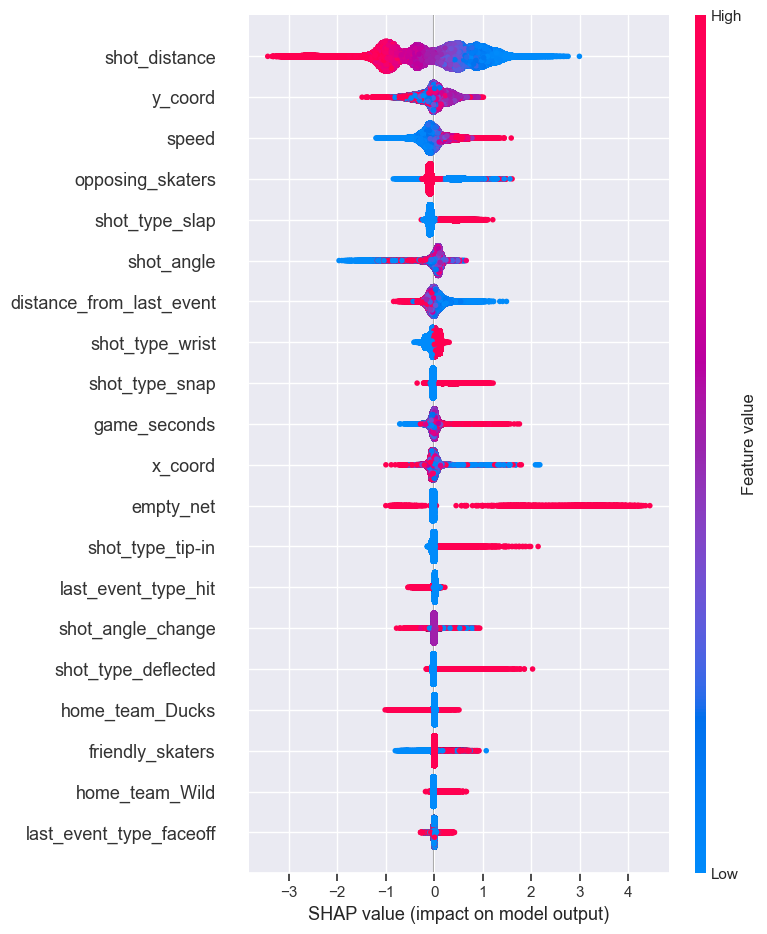

Features selected by SHAP: ['shot_distance', 'y_coord', 'speed', 'opposing_skaters', 'shot_type_slap', 'shot_angle', 'distance_from_last_event', 'shot_type_wrist', 'shot_type_snap', 'game_seconds']


In [ ]:
# Train an XGBoost model for SHAP analysis
shap_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
shap_model.fit(X_train, y_train)

# Compute SHAP values
explainer = shap.Explainer(shap_model, X_train)
shap_values = explainer(X_train)
  
# Visualize feature importance
shap.summary_plot(shap_values, X_train)


shap_importance = np.abs(shap_values.values).mean(axis=0)
top_shap_indices = np.argsort(shap_importance)[::-1][:10]
selected_features_shap = X_train.columns[top_shap_indices]
X_train_shap = X_train[selected_features_shap]
X_val_shap = X_val[selected_features_shap]

print("Features selected by SHAP:", list(selected_features_shap))


In [37]:
from sklearn.metrics import accuracy_score

def train_and_evaluate(X_train_reduced, X_val_reduced, y_train, y_val, label):
    # Train the model
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train_reduced, y_train)

    # Generate predictions
    y_pred_proba = model.predict_proba(X_val_reduced)[:, 1]
    y_pred = model.predict(X_val_reduced)  # Predict classes for accuracy

    # Generate data for ROC/AUC
    roc_data = plots.generate_roc_auc_data(y_val, y_pred_proba)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)

    # Print AUC and Accuracy
    print(f"AUC for {label}: {roc_data['roc_auc']:.3f}")
    print(f"Accuracy for {label}: {accuracy:.3f}\n")
    
    return model, roc_data, y_pred_proba, accuracy

# Train and evaluate models
model_kbest, roc_kbest, y_pred_kbest, acc_kbest = train_and_evaluate(X_train_kbest, X_val_kbest, y_train, y_val, "SelectKBest")
model_rfe, roc_rfe, y_pred_rfe, acc_rfe = train_and_evaluate(X_train_rfe, X_val_rfe, y_train, y_val, "RFE")
model_shap, roc_shap, y_pred_shap, acc_shap = train_and_evaluate(X_train_shap, X_val_shap, y_train, y_val, "SHAP")



AUC for SelectKBest: 0.757
Accuracy for SelectKBest: 0.930

AUC for RFE: 0.780
Accuracy for RFE: 0.931

AUC for SHAP: 0.768
Accuracy for SHAP: 0.930



In [38]:
# Generate predictions for the best RFE model
y_pred_proba_rfe = model_rfe.predict_proba(X_val_rfe)[:, 1]  
y_pred_rfe = (y_pred_proba_rfe >= 0.5).astype(int)          

# Generate data for the 4 plots
roc_data_rfe = plots.generate_roc_auc_data(y_val, y_pred_proba_rfe)
goal_rate_x_rfe, goal_rate_y_rfe = plots.generate_goal_rate_data(y_val, y_pred_proba_rfe)
cumulative_x_rfe, cumulative_y_rfe = plots.generate_cumulative_goal_data(y_val, y_pred_proba_rfe)
calibration_prob_pred_rfe, calibration_prob_true_rfe = plots.generate_calibration_data(y_val, y_pred_proba_rfe)


accuracy_rfe = accuracy_score(y_val, y_pred_rfe)



In [39]:
# Plot ROC/AUC
plots.plot_roc_auc([roc_data_xgb], ['XGBoost '],"roc_5_3.png")

# Plot Goal Rate vs Percentile
plots.plot_goal_rate([(goal_rate_x, goal_rate_y)], ['XGBoost'],"goal_rate_5_3.png")

# Plot Cumulative Goals vs Percentile
plots.plot_cumulative_goals([(cumulative_x, cumulative_y)], ['XGBoost'],"cumulative_goals_5_3.png")

# Plot Calibration Curve
plots.plot_calibration([y_val], [y_pred_proba], ['XGBoost'],"calibration_5_3.png")

<Figure size 1200x800 with 0 Axes>

In [40]:
wandb.init(
    project="IFT6758.2024-A",
    name="Best_Features_XGBoost_Q5_3",
    notes="Modele XGBoost avec le meilleur ensemble de caracteristiques trouvees"
)
wandb.log({
    "accuracy": accuracy_rfe,  
    "roc_auc": roc_data_rfe['roc_auc'],
})
# Log the image to W&B
wandb.log({"roc_curve_5_3": wandb.Image("roc_5_3.png", caption="ROC Curve for  5.3")})
wandb.log({"goal_rate_5_3": wandb.Image("goal_rate_5_3.png", caption="Goal Rate Curve for  5.3")})
wandb.log({"cumulative_goals_5_3": wandb.Image("cumulative_goals_5_3.png", caption="Cumulative Goald Curve for  5.3")})
wandb.log({"calibration_5_3": wandb.Image("calibration_5_3.png", caption="Calibration Curve for  5.3")})

best_model_path = "Models/features_xgboost_q5_3.json"
model_rfe.save_model(best_model_path)

# Log the model artifact
artifact = wandb.Artifact(
    name="Feature_XGBoost_Q5_3",
    type="model",
    description=" XGBoost avec le meilleur ensemble de caracteristiques trouvees"
)
artifact.add_file(best_model_path)
wandb.log_artifact(artifact)

# Finish the run
wandb.finish()

accuracy,▁
roc_auc,▁
accuracy,0.93059
roc_auc,0.77999
